In [1]:
import pandas as pd
import xarray as xr
import datetime
import numpy as np
import os
import dateutil.parser
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
path = "/home/b/b381992/OBSCabauw/"
filelist = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path,f)) and "CSV" in os.path.join(path,f)]
filelist.sort()


In [3]:
dfs = []
for filepath in filelist:
    raw_data = pd.read_csv(filepath, skiprows=1)
    height = "79"
    col = f"Horizontal Wind Speed (m/s) at {height}m"
    time_data = raw_data["Time and Date"]#[:-1]
    wind_data = np.array(raw_data[col])#[:-1]
    types = [isinstance(wd,str) for wd in wind_data]
    wind_data[np.where(types)] = np.nan
    wind_data[np.where(wind_data>1000)]=np.nan
    fmt="%d/%m/%Y %H:%M:%S"
    
    time_array = np.array([datetime.datetime.strptime(dateutil.parser.parse(time_data[0]).strftime(fmt), fmt) for single_time_data in time_data])
    dfs.append(xr.Dataset({f"w{height}m": ("time", wind_data), "time": time_array}).astype("float"))



/tmp/ipykernel_1522426/450891003.py:10: RuntimeWarning: invalid value encountered in greater
  wind_data[np.where(wind_data>1000)]=np.nan
/tmp/ipykernel_1522426/450891003.py:10: RuntimeWarning: invalid value encountered in greater
  wind_data[np.where(wind_data>1000)]=np.nan


In [4]:
df=xr.concat(dfs,dim="time")

In [5]:
df.max()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    w79m     float64 24.48

Text(0.5, 1.0, 'Wind at 79m - City: Cabauw')

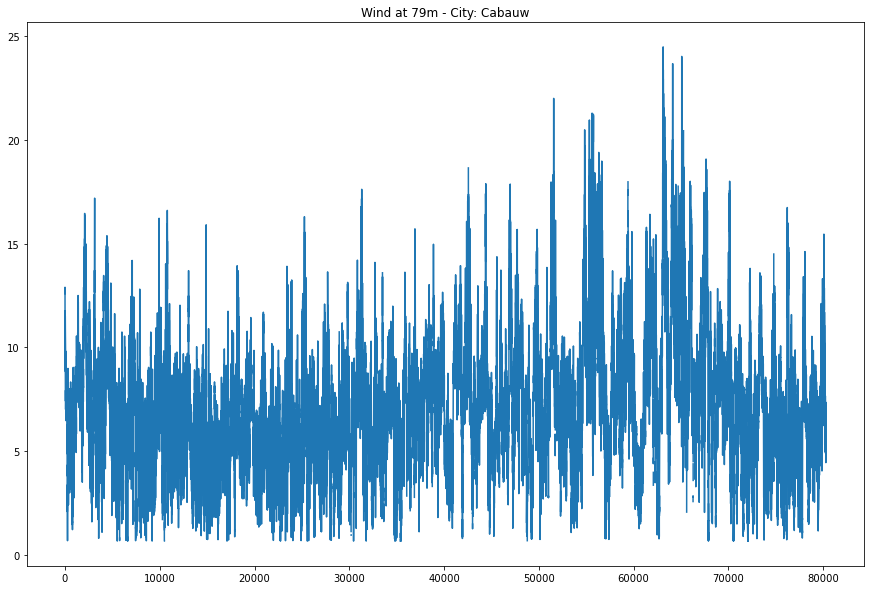

In [9]:



## Select and plot sw rad at surface for first 10 days of august
plt.figure(figsize = (15,10))
plt.plot(np.arange(len(df.time)),df[f"w{height}m"])
plt.title(f'Wind at {height}m - City: Cabauw')
#plt.savefig('../obs.png')

In [5]:
dv=df["w79m"]

In [6]:
from validation_plots import plot_metrics

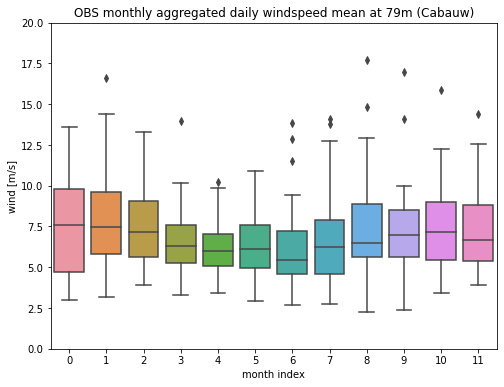

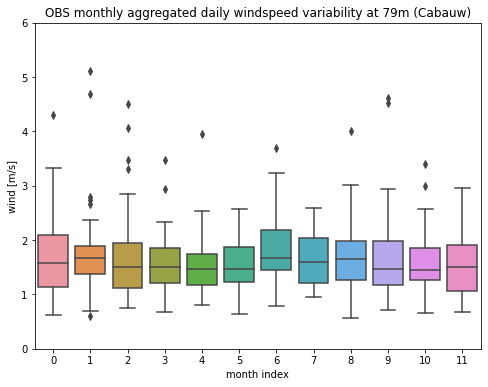

In [7]:
plot_metrics(dv,"79","OBS")

In [50]:
ds_icon = xr.open_zarr('/work/bm1235/k203123/experiments/ngc2009/outdata/ngc2009_mtgrm.zarr')
#u_station = ds_icon.u.sel(time = slice(date_ini,date_end), station = station, level = level)
ds_icon.u.isel(station=12, level=-2).time

<xarray.DataArray 'time' (time: 555120)>
array(['2020-01-20T00:02:00.000000000', '2020-01-20T00:04:00.000000000',
       '2020-01-20T00:06:00.000000000', ..., '2022-02-28T23:56:00.000000000',
       '2022-02-28T23:58:00.000000000', '2022-03-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    blk           int32 dask.array<chunksize=(), meta=np.ndarray>
    dx            int32 dask.array<chunksize=(), meta=np.ndarray>
    lat           float64 dask.array<chunksize=(), meta=np.ndarray>
    level_height  float64 dask.array<chunksize=(), meta=np.ndarray>
    lon           float64 dask.array<chunksize=(), meta=np.ndarray>
    station       <U44 'Cabauw'
  * time          (time) datetime64[ns] 2020-01-20T00:02:00 ... 2022-03-01
Attributes:
    axis:     T

In [21]:
ds_icon_lr = xr.open_zarr('/work/bm1235/m300466/experiments/ngc2012/outdata/ngc2012_mtgrm.zarr')
ds_icon_lr

/tmp/ipykernel_1432840/535369739.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds_icon_lr = xr.open_zarr('/work/bm1235/m300466/experiments/ngc2012/outdata/ngc2012_mtgrm.zarr')


GroupNotFoundError: group not found at path ''

In [29]:
res="9km"
d = xr.open_zarr(f'/work/bm1235/a270046/cycle2-sync/ddh_output/{res}')
d.time

<xarray.DataArray 'time' (time: 136703)>
array(['2020-01-20T00:15:00.000000000', '2020-01-20T00:22:30.000000000',
       '2020-01-20T00:30:00.000000000', ..., '2021-12-31T23:45:00.000000000',
       '2021-12-31T23:52:32.000000000', '2022-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T00:15:00 ... 2022-01-01